In [137]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.layers import Conv2D, BatchNormalization, Dense, MaxPooling2D, Flatten, Dropout, GlobalAveragePooling2D
import tensorflow_datasets
from tensorflow.keras.callbacks import ModelCheckpoint
import os
import math
import string
import collections
import matplotlib.pyplot as plt
import pathlib
from collections import defaultdict
import pickle 

In [27]:
AUTO = tf.data.experimental.AUTOTUNE
lrelu = tf.keras.layers.LeakyReLU(alpha=0.1)

# Data

In [21]:
image_dir = './data/1864_33884_upload_images/'
classes = os.listdir(image_dir)
classes_dict = {
    classes[x]: x
    for x in range(len(classes))
}

data_dir = pathlib.Path(image_dir)

list_ds = tf.data.Dataset.list_files(str(data_dir/'*/*'))

In [24]:
image_count = 0
for c in classes:
    for _ in range(len(os.listdir(image_dir + c))):
        image_count += 1

In [37]:
def get_label(file_path):
    # convert the path to a list of path components
    parts = tf.strings.split(file_path, os.path.sep)
    
    # The second to last is the class-directory
    t = parts[-2] == classes
    t = tf.cast(t, dtype=tf.int32)
    return t

def decode_img(img):
    # convert the compressed string to a 3D uint8 tensor
    img = tf.image.decode_jpeg(img, channels=3)
    # Use `convert_image_dtype` to convert to floats in the [0,1] range.
    img = tf.image.convert_image_dtype(img, tf.float32)
    # resize the image to the desired size.
    return tf.image.resize(img, [INPUT_SHAPE[0], INPUT_SHAPE[1]])

def process_path(file_path):
    label = get_label(file_path)

    # load the raw data from the file as a string
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label

def prepare_for_training(ds, batch_size, train=None, cache=False, shuffle_buffer_size=1000):
    # This is a small dataset, only load it once, and keep it in memory.
    # use `.cache(filename)` to cache preprocessing work for datasets that don't
    # fit in memory.
    if cache:
        if isinstance(cache, str):
            ds = ds.cache(cache)
        else:
            ds = ds.cache()
    
    if train:
        ds = ds.shuffle(buffer_size=shuffle_buffer_size)

    ds = ds.batch(batch_size)

    # `prefetch` lets the dataset fetch batches in the background while the model
    # is training.
    ds = ds.prefetch(buffer_size=AUTO)
    
    ds = ds.repeat()

    return ds


In [71]:
INPUT_SHAPE = (128, 128, 3)
BATCH_SIZE = 32
STEPS_PER_EPOCH = image_count // BATCH_SIZE

labeled_ds = list_ds.map(process_path, num_parallel_calls=AUTO)
train_ds = prepare_for_training(labeled_ds, BATCH_SIZE, train=True)

In [ ]:
def augmentation(image, labels):
    image = tf.image.resize(image, size=(128, 128))
    return image, labels

# Models

### YoloV1-Tiny

In [88]:
def build_yolov1_tiny(initalization, batchnorm):
    if batchnorm:
        model = yolov1_tiny_bn = tf.keras.Sequential([
            Conv2D(input_shape=INPUT_SHAPE, filters=16, kernel_size=(3, 3), 
                   strides=(1, 1), padding='same', activation=lrelu, kernel_initializer=initalization),
            BatchNormalization(),
            MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
            Conv2D(filters=32, kernel_size=(3, 3), strides=(1, 1), 
                   padding='same', activation=lrelu, kernel_initializer=initalization),
            BatchNormalization(),
            MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
            Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), 
                   padding='same', activation=lrelu, kernel_initializer=initalization),
            BatchNormalization(),
            MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
            Conv2D(filters=128, kernel_size=(3, 3), strides=(1, 1), 
                   padding='same', activation=lrelu, kernel_initializer=initalization),
            BatchNormalization(),
            MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
            Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), 
                   padding='same', activation=lrelu, kernel_initializer=initalization),
            BatchNormalization(),
            MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
            Conv2D(filters=512, kernel_size=(3, 3), strides=(1, 1), 
                   padding='same', activation=lrelu, kernel_initializer=initalization),
            BatchNormalization(),
            MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
            Conv2D(filters=1024, kernel_size=(3, 3), strides=(1, 1), 
                   padding='same', activation=lrelu, kernel_initializer=initalization),
            BatchNormalization(),
            Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), 
                   padding='same', activation=lrelu, kernel_initializer=initalization),
            BatchNormalization(),
            Flatten(),
            Dense(1470, kernel_initializer=initalization),
            Dense(101, kernel_initializer=initalization, activation='softmax')
        ])
        
        return model
    
    else:
        model = yolov1_tiny_bn = tf.keras.Sequential([
            Conv2D(input_shape=INPUT_SHAPE, filters=16, kernel_size=(3, 3), 
                   strides=(1, 1), padding='same', activation=lrelu, kernel_initializer=initalization),
            MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
            Conv2D(filters=32, kernel_size=(3, 3), strides=(1, 1), 
                   padding='same', activation=lrelu, kernel_initializer=initalization),
            MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
            Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), 
                   padding='same', activation=lrelu, kernel_initializer=initalization),
            MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
            Conv2D(filters=128, kernel_size=(3, 3), strides=(1, 1), 
                   padding='same', activation=lrelu, kernel_initializer=initalization),
            MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
            Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), 
                   padding='same', activation=lrelu, kernel_initializer=initalization),
            MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
            Conv2D(filters=512, kernel_size=(3, 3), strides=(1, 1), 
                   padding='same', activation=lrelu, kernel_initializer=initalization),
            MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
            Conv2D(filters=1024, kernel_size=(3, 3), strides=(1, 1), 
                   padding='same', activation=lrelu, kernel_initializer=initalization),
            Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), 
                   padding='same', activation=lrelu, kernel_initializer=initalization),
            Flatten(),
            Dense(1470, kernel_initializer=initalization),
            Dense(101, kernel_initializer=initalization, activation='softmax')
        ])
        
        return model
        

#### Training loop: please alter lines 8 (initializer) and 10 (batchnorm)

In [149]:
yolov1_tiny_bn_results = defaultdict()

for n in range(3):
    seed = np.random.randint(1111)
    yolov1_tiny_bn_results[n] = defaultdict()
    yolov1_tiny_bn_results[n]['seed'] = seed
    
    he_norm = tf.keras.initializers.he_normal(seed)
    
    yolov1_tiny_bn = build_yolov1_tiny(initalization=he_norm, batchnorm=False)
    
    yolov1_tiny_bn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    
    history = yolov1_tiny_bn.fit(
        train_ds,
        epochs=50,
        steps_per_epoch=STEPS_PER_EPOCH
    )
    
    yolov1_tiny_bn_results[n]['loss'] = history.history['loss']
    yolov1_tiny_bn_results[n]['acc'] = history.history['categorical_accuracy']

Train for 3156 steps
Epoch 1/50
3156/3156 [==============================] - 68s 22ms/step - loss: nan - categorical_accuracy: 0.0099
Epoch 2/50
 288/3156 [=>............................] - ETA: 1:14 - loss: nan - categorical_accuracy: 0.0099

KeyboardInterrupt: 

In [116]:
with open('./results/tiny_yolo_no_saxe', 'wb') as handle:
    pickle.dump(yolov1_tiny_bn_results, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [150]:
del yolov1_tiny_bn

# ResNet18

In [145]:
class BasicBlockBN(tf.keras.layers.Layer):

    def __init__(self, filter_num, initializer, stride=1):
        super(BasicBlockBN, self).__init__()
        self.conv1 = tf.keras.layers.Conv2D(filters=filter_num,
                                            kernel_size=(3, 3),
                                            strides=stride,
                                            padding="same",
                                            kernel_initializer=initializer,
                                            activation='relu')
        self.bn1 = tf.keras.layers.BatchNormalization()
        self.conv2 = tf.keras.layers.Conv2D(filters=filter_num,
                                            kernel_size=(3, 3),
                                            strides=1,
                                            padding="same",
                                            kernel_initializer=initializer,
                                            activation='relu')
        self.bn2 = tf.keras.layers.BatchNormalization()
        if stride != 1:
            self.downsample = tf.keras.Sequential()
            self.downsample.add(tf.keras.layers.Conv2D(filters=filter_num,
                                                       kernel_size=(1, 1),
                                                       strides=stride,
                                                       kernel_initializer=initializer,
                                                       activation='relu'))
            self.downsample.add(tf.keras.layers.BatchNormalization())
        else:
            self.downsample = lambda x: x

    def call(self, inputs, training=None, **kwargs):
        residual = self.downsample(inputs)

        x = self.conv1(inputs)
        x = self.bn1(x, training=training)
        x = tf.nn.relu(x)
        x = self.conv2(x)
        x = self.bn2(x, training=training)

        output = tf.nn.relu(tf.keras.layers.add([residual, x]))

        return output
    
class BasicBlockNO(tf.keras.layers.Layer):

    def __init__(self, filter_num, initializer, stride=1):
        super(BasicBlockNO, self).__init__()
        self.conv1 = tf.keras.layers.Conv2D(filters=filter_num,
                                            kernel_size=(3, 3),
                                            strides=stride,
                                            padding="same",
                                            kernel_initializer=initializer,
                                            activation='relu')
        self.conv2 = tf.keras.layers.Conv2D(filters=filter_num,
                                            kernel_size=(3, 3),
                                            strides=1,
                                            padding="same",
                                            kernel_initializer=initializer,
                                            activation='relu')
        if stride != 1:
            self.downsample = tf.keras.Sequential()
            self.downsample.add(tf.keras.layers.Conv2D(filters=filter_num,
                                                       kernel_size=(1, 1),
                                                       strides=stride,
                                                       kernel_initializer=initializer,
                                                       activation='relu'))
        else:
            self.downsample = lambda x: x

    def call(self, inputs, training=None, **kwargs):
        residual = self.downsample(inputs)

        x = self.conv1(inputs)
        x = tf.nn.relu(x)
        x = self.conv2(x)

        output = tf.nn.relu(tf.keras.layers.add([residual, x]))

        return output

def make_basic_block_layer(filter_num, blocks, initializer, batchnorm, stride=1):
    res_block = tf.keras.Sequential()
    
    if batchnorm:
        res_block.add(BasicBlockBN(filter_num, stride=stride, initializer=initializer))

        for _ in range(1, blocks):
            res_block.add(BasicBlockBN(filter_num, stride=1, initializer=initializer))

        return res_block
    
    else:
        res_block.add(BasicBlockNO(filter_num, stride=stride, initializer=initializer))
        
        for _ in range(1, blocks):
            res_block.add(BasicBlockNO(filter_num, stride=1, initializer=initializer))
            
        return res_block

In [146]:
def build_resnet18(initializer, batchnorm):
    model = tf.keras.Sequential([
        Conv2D(input_shape=INPUT_SHAPE, filters=64, kernel_size=(7, 7), 
               strides=2, padding='same', kernel_initializer=initializer, activation='relu'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2), strides=2, padding='same'),

        # Each one of these is 2 BasicBlock
        make_basic_block_layer(filter_num=64, blocks=2, stride=2, 
                               initializer=initializer, batchnorm=batchnorm),
        make_basic_block_layer(filter_num=128, blocks=2, stride=2, 
                               initializer=initializer, batchnorm=batchnorm),
        make_basic_block_layer(filter_num=256, blocks=2, stride=2, 
                               initializer=initializer, batchnorm=batchnorm),
        make_basic_block_layer(filter_num=512, blocks=2, stride=2, 
                               initializer=initializer, batchnorm=batchnorm),
        GlobalAveragePooling2D(),
        Dense(101, kernel_initializer=initializer, activation='softmax')

    ])

    return model

#### Training loop: please alter lines 8 (initializer) and 10 (batchnorm)

In [156]:
resnet_bn_results = defaultdict()

for n in range(3):
    seed = np.random.randint(1111)
    resnet_bn_results[n] = defaultdict()
    resnet_bn_results[n]['seed'] = seed
    
    he_norm = tf.keras.initializers.he_normal(seed)
    
    resnet = build_resnet18(initializer=he_norm, batchnorm=True)
    
    resnet.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    
    history = resnet.fit(
        train_ds,
        epochs=50,
        steps_per_epoch=STEPS_PER_EPOCH
    )
    
    resnet_bn_results[n]['loss'] = history.history['loss']
    resnet_bn_results[n]['acc'] = history.history['categorical_accuracy']

Train for 3156 steps
Epoch 1/50
3156/3156 [==============================] - 99s 31ms/step - loss: 4.5141 - categorical_accuracy: 0.0509
Epoch 2/50
3156/3156 [==============================] - 99s 31ms/step - loss: 3.7481 - categorical_accuracy: 0.1414
Epoch 3/50
3156/3156 [==============================] - 97s 31ms/step - loss: 3.2651 - categorical_accuracy: 0.2211
Epoch 4/50
3156/3156 [==============================] - 99s 31ms/step - loss: 2.8902 - categorical_accuracy: 0.2926
Epoch 5/50
3156/3156 [==============================] - 100s 32ms/step - loss: 2.5750 - categorical_accuracy: 0.3565
Epoch 6/50
3156/3156 [==============================] - 98s 31ms/step - loss: 2.2768 - categorical_accuracy: 0.4176
Epoch 7/50
3156/3156 [==============================] - 99s 32ms/step - loss: 1.9875 - categorical_accuracy: 0.4791
Epoch 8/50
3156/3156 [==============================] - 101s 32ms/step - loss: 1.7015 - categorical_accuracy: 0.5427
Epoch 9/50
3156/3156 [===========================

3156/3156 [==============================] - 101s 32ms/step - loss: 0.3033 - categorical_accuracy: 0.9042
Epoch 21/50
3156/3156 [==============================] - 97s 31ms/step - loss: 0.2841 - categorical_accuracy: 0.9104
Epoch 22/50
3156/3156 [==============================] - 99s 31ms/step - loss: 0.2729 - categorical_accuracy: 0.9139
Epoch 23/50
3156/3156 [==============================] - 97s 31ms/step - loss: 0.2582 - categorical_accuracy: 0.9173
Epoch 24/50
3156/3156 [==============================] - 100s 32ms/step - loss: 0.2468 - categorical_accuracy: 0.9219
Epoch 25/50
3156/3156 [==============================] - 100s 32ms/step - loss: 0.2236 - categorical_accuracy: 0.9284
Epoch 26/50
3156/3156 [==============================] - 98s 31ms/step - loss: 0.2202 - categorical_accuracy: 0.9301
Epoch 27/50
3156/3156 [==============================] - 99s 31ms/step - loss: 0.2139 - categorical_accuracy: 0.9323
Epoch 28/50
3156/3156 [==============================] - 101s 32ms/step -

3156/3156 [==============================] - 98s 31ms/step - loss: 0.1444 - categorical_accuracy: 0.9544
Epoch 40/50
3156/3156 [==============================] - 99s 31ms/step - loss: 0.1395 - categorical_accuracy: 0.9549
Epoch 41/50
3156/3156 [==============================] - 101s 32ms/step - loss: 0.1292 - categorical_accuracy: 0.9583
Epoch 42/50
3156/3156 [==============================] - 97s 31ms/step - loss: 0.1348 - categorical_accuracy: 0.9575
Epoch 43/50
3156/3156 [==============================] - 99s 31ms/step - loss: 0.1261 - categorical_accuracy: 0.9597
Epoch 44/50
3156/3156 [==============================] - 100s 32ms/step - loss: 0.1253 - categorical_accuracy: 0.9594
Epoch 45/50
3156/3156 [==============================] - 97s 31ms/step - loss: 0.1228 - categorical_accuracy: 0.9601
Epoch 46/50
3156/3156 [==============================] - 99s 31ms/step - loss: 0.1167 - categorical_accuracy: 0.9627
Epoch 47/50
3156/3156 [==============================] - 101s 32ms/step - 

In [157]:
with open('./results/resnet_bn_he', 'wb') as handle:
    pickle.dump(resnet_bn_results, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [158]:
resnet_bn_results = defaultdict()

for n in range(3):
    seed = np.random.randint(1111)
    resnet_bn_results[n] = defaultdict()
    resnet_bn_results[n]['seed'] = seed
    
    he_norm = tf.keras.initializers.he_normal(seed)
    
    resnet = build_resnet18(initializer=he_norm, batchnorm=False)
    
    resnet.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    
    history = resnet.fit(
        train_ds,
        epochs=50,
        steps_per_epoch=STEPS_PER_EPOCH
    )
    
    resnet_bn_results[n]['loss'] = history.history['loss']
    resnet_bn_results[n]['acc'] = history.history['categorical_accuracy']

Train for 3156 steps
Epoch 1/50
3156/3156 [==============================] - 82s 26ms/step - loss: 4.2748 - categorical_accuracy: 0.0693
Epoch 2/50
3156/3156 [==============================] - 81s 26ms/step - loss: 3.7264 - categorical_accuracy: 0.1414
Epoch 3/50
3156/3156 [==============================] - 85s 27ms/step - loss: 3.4384 - categorical_accuracy: 0.19080s - loss: 3.4384 - categorical_accuracy: 0.
Epoch 4/50
3156/3156 [==============================] - 83s 26ms/step - loss: 3.1996 - categorical_accuracy: 0.2315
Epoch 5/50
3156/3156 [==============================] - 87s 27ms/step - loss: 2.9633 - categorical_accuracy: 0.2746
Epoch 6/50
3156/3156 [==============================] - 84s 27ms/step - loss: 2.7159 - categorical_accuracy: 0.3232
Epoch 7/50
3156/3156 [==============================] - 82s 26ms/step - loss: 2.4321 - categorical_accuracy: 0.3784
Epoch 8/50
3156/3156 [==============================] - 86s 27ms/step - loss: 2.1141 - categorical_accuracy: 0.4464
Epoch 9

3156/3156 [==============================] - 82s 26ms/step - loss: 0.4513 - categorical_accuracy: 0.8654
Epoch 21/50
3156/3156 [==============================] - 86s 27ms/step - loss: 0.4368 - categorical_accuracy: 0.8687
Epoch 22/50
3156/3156 [==============================] - 83s 26ms/step - loss: 0.4125 - categorical_accuracy: 0.8760
Epoch 23/50
3156/3156 [==============================] - 86s 27ms/step - loss: 0.4028 - categorical_accuracy: 0.8786
Epoch 24/50
3156/3156 [==============================] - 84s 27ms/step - loss: 0.3801 - categorical_accuracy: 0.8871
Epoch 25/50
3156/3156 [==============================] - 82s 26ms/step - loss: 0.3590 - categorical_accuracy: 0.8928
Epoch 26/50
3156/3156 [==============================] - 85s 27ms/step - loss: 0.3621 - categorical_accuracy: 0.8933
Epoch 27/50
3156/3156 [==============================] - 83s 26ms/step - loss: 0.3450 - categorical_accuracy: 0.8980
Epoch 28/50
3156/3156 [==============================] - 86s 27ms/step - los

3156/3156 [==============================] - 86s 27ms/step - loss: 0.3865 - categorical_accuracy: 0.8899
Epoch 40/50
3156/3156 [==============================] - 85s 27ms/step - loss: 0.3841 - categorical_accuracy: 0.8903
Epoch 41/50
3156/3156 [==============================] - 87s 28ms/step - loss: 0.3858 - categorical_accuracy: 0.8914
Epoch 42/50
3156/3156 [==============================] - 85s 27ms/step - loss: 0.3764 - categorical_accuracy: 0.8939
Epoch 43/50
3156/3156 [==============================] - 80s 25ms/step - loss: 0.3820 - categorical_accuracy: 0.8925
Epoch 44/50
3156/3156 [==============================] - 85s 27ms/step - loss: 0.3787 - categorical_accuracy: 0.8943
Epoch 45/50
3156/3156 [==============================] - 83s 26ms/step - loss: 0.3791 - categorical_accuracy: 0.8943
Epoch 46/50
3156/3156 [==============================] - 82s 26ms/step - loss: 0.3816 - categorical_accuracy: 0.8947
Epoch 47/50
3156/3156 [==============================] - 85s 27ms/step - los

In [159]:
with open('./results/resnet_no_he', 'wb') as handle:
    pickle.dump(resnet_bn_results, handle, protocol=pickle.HIGHEST_PROTOCOL)

### Compiling the results

In [165]:
result_files = [
    './results/tiny_yolo_bn_glorot',
    './results/tiny_yolo_no_glorot',
    './results/tiny_yolo_bn_he',
    './results/tiny_yolo_no_he',
    './results/resnet_bn_glorot',
    './results/resnet_no_glorot',
    './results/resnet_bn_he',
    './results/resnet_no_he'
]

compiled_results = defaultdict()

for file in result_files:
#     compiled_results[file] = defaultdict()
    with (open(file, "rb")) as openfile:
        compiled_results[file] = pickle.load(openfile)

In [168]:
compiled_results.keys()

dict_keys(['./results/tiny_yolo_bn_glorot', './results/tiny_yolo_no_glorot', './results/tiny_yolo_bn_he', './results/tiny_yolo_no_he', './results/resnet_bn_glorot', './results/resnet_no_glorot', './results/resnet_bn_he', './results/resnet_no_he'])

In [171]:
compiled_results[result_files[0]][0]

defaultdict(None,
            {'seed': 787,
             'loss': [5.304878088533501,
              3.59651102143945,
              3.0448399563332895,
              2.624449200301869,
              2.27506362463402,
              1.9487364142342118,
              1.6218299591241874,
              1.302851586700402,
              1.0203673682871357,
              0.801876742959202,
              0.6559512710412608,
              0.5451499699705632,
              0.47989560792156355,
              0.4156277360052647,
              0.3871567887960613,
              0.35108316606374806,
              0.32250803510885206,
              0.30672191306665303,
              0.2878888919161438,
              0.27383933867277765,
              0.26069272469905397,
              0.2528087962371568,
              0.24145316863235503,
              0.2335061988257661,
              0.22556734054728872,
              0.21723504052190104,
              0.21262969856941716,
              0.208437565483

#### Tiny-Yolo BN

In [179]:
ty_bn = ['./results/tiny_yolo_bn_glorot','./results/tiny_yolo_bn_he']

ty_bn_g = compiled_results[ty_bn[0]]

ty_bn_g_acc = list()
for iteration in ty_bn_g.keys():
    ty_bn_g_acc.append(ty_bn_g[iteration]['acc'])    

ty_bn_h = compiled_results[ty_bn[1]]

ty_bn_h_acc = list()
for iteration in ty_bn_g.keys():
    ty_bn_h_acc.append(ty_bn_h[iteration]['acc'][:50]) # started out at 100 iters per

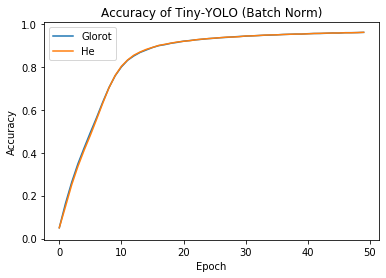

In [188]:
plt.plot(np.mean(ty_bn_g_acc, axis=0))
plt.fill_between([x for x in range(50)], 
                 np.min(ty_bn_g_acc, axis=0), 
                 np.max(ty_bn_g_acc, axis=0), alpha=0.2)

plt.plot(np.mean(ty_bn_h_acc, axis=0))
plt.fill_between([x for x in range(50)], 
                 np.min(ty_bn_h_acc, axis=0), 
                 np.max(ty_bn_h_acc, axis=0), alpha=0.2)

plt.title('Accuracy of Tiny-YOLO (Batch Norm)')
plt.legend(['Glorot', 'He'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.savefig('./results/ty_bn.png', dpi=400)

#### Tiny-Tolo NO

In [206]:
ty_bn = ['./results/tiny_yolo_no_glorot','./results/tiny_yolo_no_he']

ty_bn_g = compiled_results[ty_bn[0]]

ty_bn_g_acc = list()
for iteration in ty_bn_g.keys():
    ty_bn_g_acc.append(ty_bn_g[iteration]['acc'])    

ty_bn_h = compiled_results[ty_bn[1]]

ty_bn_h_acc = list()
for iteration in ty_bn_g.keys():
    ty_bn_h_acc.append(ty_bn_h[iteration]['acc'][:50]) # started out at 100 iters per

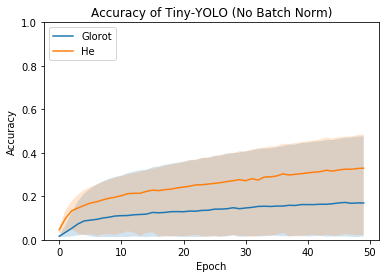

In [207]:
plt.plot(np.mean(ty_bn_g_acc, axis=0))
plt.fill_between([x for x in range(50)], 
                 np.min(ty_bn_g_acc, axis=0), 
                 np.max(ty_bn_g_acc, axis=0), alpha=0.2)

plt.plot(np.mean(ty_bn_h_acc, axis=0))
plt.fill_between([x for x in range(50)], 
                 np.min(ty_bn_h_acc, axis=0), 
                 np.max(ty_bn_h_acc, axis=0), alpha=0.2)

plt.title('Accuracy of Tiny-YOLO (No Batch Norm)')
plt.legend(['Glorot', 'He'], loc=2)
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.ylim(0, 1)
plt.savefig('./results/ty_no.png', dpi=400)

#### ResNet BN

In [200]:
ty_bn = ['./results/resnet_bn_glorot','./results/resnet_bn_he']

ty_bn_g = compiled_results[ty_bn[0]]

ty_bn_g_acc = list()
for iteration in ty_bn_g.keys():
    ty_bn_g_acc.append(ty_bn_g[iteration]['acc'])    

ty_bn_h = compiled_results[ty_bn[1]]

ty_bn_h_acc = list()
for iteration in ty_bn_g.keys():
    ty_bn_h_acc.append(ty_bn_h[iteration]['acc'][:50]) # started out at 100 iters per

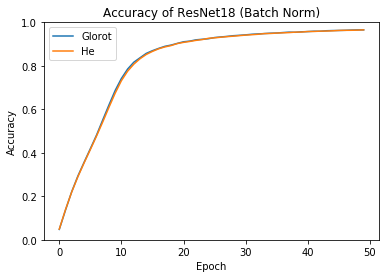

In [202]:
plt.plot(np.mean(ty_bn_g_acc, axis=0))
plt.fill_between([x for x in range(50)], 
                 np.min(ty_bn_g_acc, axis=0), 
                 np.max(ty_bn_g_acc, axis=0), alpha=0.2)

plt.plot(np.mean(ty_bn_h_acc, axis=0))
plt.fill_between([x for x in range(50)], 
                 np.min(ty_bn_h_acc, axis=0), 
                 np.max(ty_bn_h_acc, axis=0), alpha=0.2)

plt.title('Accuracy of ResNet18 (Batch Norm)')
plt.legend(['Glorot', 'He'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.ylim(0, 1)
plt.savefig('./results/res_bn.png', dpi=400)

#### ResNet NO

In [203]:
ty_bn = ['./results/resnet_no_glorot','./results/resnet_no_he']

ty_bn_g = compiled_results[ty_bn[0]]

ty_bn_g_acc = list()
for iteration in ty_bn_g.keys():
    ty_bn_g_acc.append(ty_bn_g[iteration]['acc'])    

ty_bn_h = compiled_results[ty_bn[1]]

ty_bn_h_acc = list()
for iteration in ty_bn_g.keys():
    ty_bn_h_acc.append(ty_bn_h[iteration]['acc'][:50]) # started out at 100 iters per

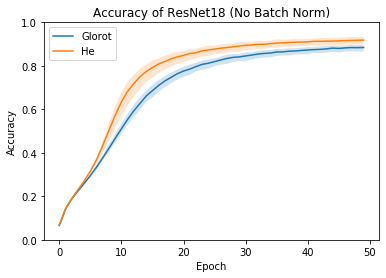

In [204]:
plt.plot(np.mean(ty_bn_g_acc, axis=0))
plt.fill_between([x for x in range(50)], 
                 np.min(ty_bn_g_acc, axis=0), 
                 np.max(ty_bn_g_acc, axis=0), alpha=0.2)

plt.plot(np.mean(ty_bn_h_acc, axis=0))
plt.fill_between([x for x in range(50)], 
                 np.min(ty_bn_h_acc, axis=0), 
                 np.max(ty_bn_h_acc, axis=0), alpha=0.2)

plt.title('Accuracy of ResNet18 (No Batch Norm)')
plt.legend(['Glorot', 'He'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.ylim(0, 1)
plt.savefig('./results/res_no.png', dpi=400)